# Regresió Logística Multinomial
Model neuronal basat en: https://en.wikipedia.org/wiki/Multinomial_logistic_regression

Paleta de colors utilitzada: https://coolors.co/palette/ef476f-ffd166-06d6a0-118ab2-073b4c

In [1]:
# dependencies
import pandas as pd
import numpy as np
import time
import copy
import pickle

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split

#### Dataset
***

In [2]:
class DatasetEscenaris(Dataset):
    """Classe que gestiona les dades tabulars tal que es puguin
    utilitzar en models pytorch còmodament."""

    def __init__(self, fitxer):
        self.dades = pd.read_csv(fitxer)
        self.objectiu = "Escenari"

        self.X = self.dades.drop(["Node", self.objectiu], axis=1)
        self.y = self.dades[self.objectiu]

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        if isinstance(idx, torch.Tensor):
            idx = idx.tolist()

        return [self.X.iloc[idx].values, self.y[idx]]
    

#### Model de Regresió Logística Multinomial
***

In [3]:
class LR_MN_Model(nn.Module):
    def __init__(self, input_size):
        super(LR_MN_Model, self).__init__()
        self.linear = nn.Linear(input_size, 42, bias=True)
        self.softmax = nn.Softmax(dim=1) # funcio sortida per a regresions logístiques multinomials
    
    def forward(self, x):
        return self.softmax(self.linear(x))  
    

#### Entrenament
***

In [4]:
# Inicialitzar i carregar les dades
entrenament = DatasetEscenaris("all_scenarios_train.csv") # train set
validacio = DatasetEscenaris("all_scenarios_test.csv")    # test set

X_entrenament = entrenament.X 
y_entrenament = entrenament.y

X_validacio = validacio.X     
y_validacio = validacio.y

# Separació per a fer la classificacio multicalsse: 41 escenaris 
y_entrenament_mc = np.zeros((y_entrenament.size, 42))
y_entrenament_mc[np.arange(y_entrenament.size), y_entrenament] = 1

y_validacio_mc = np.zeros((y_validacio.size, 42))
y_validacio_mc[np.arange(y_validacio.size), y_validacio] = 1

y_entrenament = np.array(y_entrenament)[:, np.newaxis]
y_validacio = np.array(y_validacio)[:, np.newaxis]

print('Dades entrenament:', X_entrenament.shape)
print('Etiqs entrenament:', y_entrenament.shape)
print('Etiqs entrenament multiclasse:', y_entrenament_mc.shape)
print('Dades validació:', X_validacio.shape)
print('Etiqs validació:', y_validacio.shape)
print('Etiqs validació multiclasse:', y_validacio_mc.shape)

Dades entrenament: (19866, 4)
Etiqs entrenament: (19866, 1)
Etiqs entrenament multiclasse: (19866, 42)
Dades validació: (4362, 4)
Etiqs validació: (4362, 1)
Etiqs validació multiclasse: (4362, 42)


In [5]:
# Definició de paràmetres
n_epoques = 15
model = LR_MN_Model(X_entrenament.shape[1])
criteri = nn.CrossEntropyLoss()
optimitzador = torch.optim.Adam(model.parameters(), weight_decay=1)
historial_precisions = [] 
historial_perdues = []

In [6]:
# Cos de l'entrenament
inici = time.time()
millor_precisio = 0.0
pesos_millor_model = copy.deepcopy(model.state_dict())

for epoca in range(n_epoques):
    print("Època " + str(epoca) + "/" + str(n_epoques - 1))
    print('-' * 10)
        
    # batch aleatori
    rbatch = np.random.choice(y_entrenament.size, size=64)  # size = batch
    
    # Inicialitzem les dades d'aquesta epoca segons el batch aleatori escollit
    X_entr = torch.autograd.Variable(torch.FloatTensor(X_entrenament.values[rbatch]))
    y_entr = torch.autograd.Variable(torch.FloatTensor(y_entrenament_mc[rbatch]))
    # training, metrics and storage
    optimitzador.zero_grad()
    
    outputs = model(X_entr)
    perdua = criteri(outputs, y_entr)
    perdua.backward()
    optimitzador.step()

    X_val = torch.autograd.Variable(torch.FloatTensor(X_validacio.values))
    y_val = torch.autograd.Variable(torch.FloatTensor(y_validacio_mc))

    perdua_epoca = perdua.detach().numpy()
    precisio_epoca = torch.mean(1 - torch.abs(y_val - model(X_val))).detach().numpy()*100
    
    # copia profunda del model amb els millors resultats
    if precisio_epoca > millor_precisio:
        millor_precisio = precisio_epoca
        pesos_millor_model = copy.deepcopy(model.state_dict())

    historial_perdues.append(perdua_epoca)
    historial_precisions.append(precisio_epoca)
    
    print('perdua: {:.4f} precisió: {:.6f}% \n'.format(perdua_epoca, precisio_epoca))
    
temps_total = time.time() - inici
print("Entrenament completat en {:.6f}m {:.6f}s".format(temps_total // 60, temps_total % 60))
print("Millor precisió: {:.6f}%".format(millor_precisio))

Època 0/14
----------
perdua: 3.7308 precisió: 95.515424% 

Època 1/14
----------
perdua: 3.7464 precisió: 95.515424% 

Època 2/14
----------
perdua: 3.6996 precisió: 95.515501% 

Època 3/14
----------
perdua: 3.7153 precisió: 95.515800% 

Època 4/14
----------
perdua: 3.7150 precisió: 95.515555% 

Època 5/14
----------
perdua: 3.7309 precisió: 95.515555% 

Època 6/14
----------
perdua: 3.7620 precisió: 95.515674% 

Època 7/14
----------
perdua: 3.7621 precisió: 95.515960% 

Època 8/14
----------
perdua: 3.7150 precisió: 95.516300% 

Època 9/14
----------
perdua: 3.6996 precisió: 95.516437% 

Època 10/14
----------
perdua: 3.6840 precisió: 95.516473% 

Època 11/14
----------
perdua: 3.7308 precisió: 95.516437% 

Època 12/14
----------
perdua: 3.6683 precisió: 95.516354% 

Època 13/14
----------
perdua: 3.6684 precisió: 95.515859% 

Època 14/14
----------
perdua: 3.7621 precisió: 95.515555% 

Entrenament completat en 0.000000m 0.250311s
Millor precisió: 95.516473%


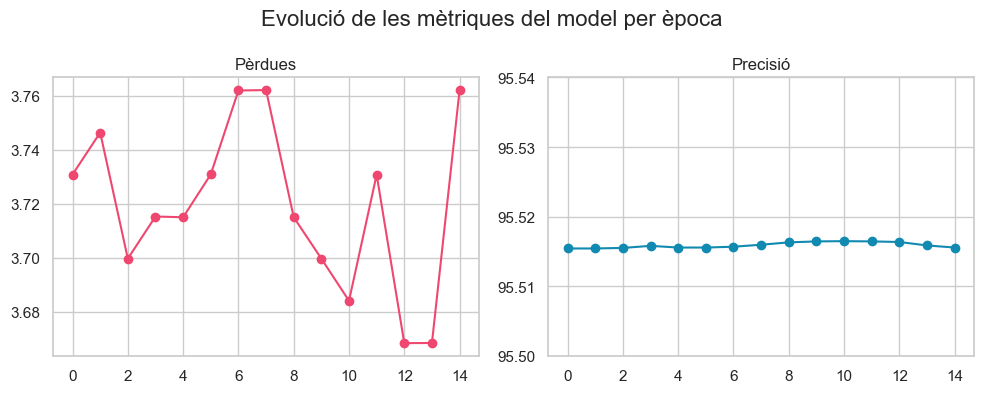

In [13]:
# comparació de solucionadors en les dades originals vs les estandaritzades
fig, axs = plt.subplots(1, 2, figsize=(10, 4))

axs[0].plot(historial_perdues, "o-", color = "#EF476F")
axs[0].set_title('Pèrdues')

axs[1].plot(historial_precisions, "o-", color = "#118AB2")
axs[1].set_title('Precisió')
axs[1].set_yticks([95.50, 95.51, 95.52, 95.53, 95.54])

fig.suptitle("Evolució de les mètriques del model per època", fontsize=16)
fig.tight_layout()
plt.show()

In [8]:
# Guardar el model trobat per a usos posteriors
filename = 'reg_log_multinom_pytorch.sav'
pickle.dump(model, open("Models/"+filename, 'wb'))